# Exploración de Datos

En este notebook, exploraremos el dataset de reseñas bancarias.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
# Download latest version
path = kagglehub.dataset_download("dhavalrupapara/banks-customer-reviews-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\dhavalrupapara\banks-customer-reviews-dataset\versions\1


In [4]:
# Cargar el dataset en un dataframe
df = pd.read_csv(f"{path}\\bank_reviews3.csv")

# Mostrar las primeras filas del dataframe
df.head()

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.2+ KB


## Informacion de la data

| *Column Names* | *Description* |
| --- | --- |
| author | The user who authored the review, providing valuable insights into the reviewer's identity and perspective. |
| date | The date when the review was submitted, offering a temporal dimension to the dataset and enabling time-based analysis. |
| address | The geographical location from which the review was written, contributing to understanding regional trends and variations in banking experiences. |
| bank | The name of the reviewed bank, serving as a key identifier for the financial institution being assessed. |
| rating | The user's numerical assessment of the bank's service, indicating user satisfaction on a numerical scale. |
| review title by user | The user-assigned title to their review, summarizing the essence of their feedback in a concise manner. |
| review | The detailed content of the user's review about the bank, providing the primary textual data for analysis and insights. |
| bank image | The URL pointing to the bank's logo or image relevant to the review, facilitating visual associations with the bank. |
| rating title by user | The user-assigned title to their rating, potentially offering additional context to the rating value. |
| useful count | The count of users who found the review helpful, reflecting the impact and usefulness of the review among other users. |

In [6]:
df.bank.value_counts()

review                  285
SBI                     219
HDFC Bank               188
Axis Bank               131
Kotak                    80
Canara Bank              35
IndusInd Bank            20
IDBI                     14
Citibank                 14
Punjab National Bank     14
Name: bank, dtype: int64

## Distribución de calificaciones por rating

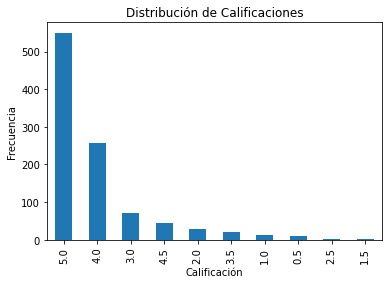

In [7]:
ax = df['rating'].value_counts().plot(kind='bar')
ax.set_title('Distribución de Calificaciones')
ax.set_xlabel('Calificación')
ax.set_ylabel('Frecuencia')
plt.show()

Existe un fuerte sesgo hacia las calificaciones altas.

Las calificaciones menores a 3.0 son mucho menos frecuentes, lo que podría generar problemas al entrenar un modelo de Machine Learning, ya que tendrá menos ejemplos de calificaciones bajas para aprender.

- Si el modelo aprende con estos datos tal cual, podría sesgarse hacia predecir calificaciones altas con más frecuencia.
- Podríamos necesitar técnicas de balanceo de datos, como oversampling de las clases minoritarias o undersampling de las clases mayoritarias.
- También podríamos agrupar las calificaciones en categorías más amplias (por ejemplo, "Baja", "Media" y "Alta") para facilitar el aprendizaje del modelo.

Las decisiones frente a esto las tomaremos en la etapa de procesamiento de datos.

## Longitud del texto en las reseñas

In [8]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
df['review_length'].describe()

count    1000.000000
mean       58.765000
std        11.722593
min        40.000000
25%        51.000000
50%        57.000000
75%        63.000000
max       181.000000
Name: review_length, dtype: float64

In [9]:
# Calcular el IQR de la longitud de las reseñas
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")

Q1: 51.0
Q3: 63.0
IQR: 12.0


El rango intercuartil (IQR) está entre 51 y 63 palabras, lo que muestra que el 50% de las reseñas están dentro de un margen relativamente estrecho.

- Las reseñas muy cortas pueden ser ambiguas y no proporcionar suficiente información útil para el modelo. Podríamos considerar eliminarlas o tratarlas con técnicas específicas.
- Las reseñas muy largas pueden generar ruido, ya que podrían incluir información irrelevante o divagar demasiado.
- Distribución desigual: Si la mayoría de las reseñas tienen entre 50 y 60 palabras, el modelo podría tener dificultades para interpretar aquellas que son mucho más cortas o largas.

## Correlación entre el texto de la reseña y rating asignado

In [10]:
# Vectorizar con TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(df['review']).toarray()

In [11]:
y_rating = df['rating']

In [12]:
# Calcular la correlación entre cada palabra TF-IDF y la calificación
correlations = [spearmanr(X_tfidf[:, i], y_rating)[0] for i in range(X_tfidf.shape[1])]

In [13]:
# Crear un DataFrame con los resultados
df_corr = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'correlation': correlations})


In [14]:
# Ordenar por correlación absoluta (más relevantes)
df_corr = df_corr.reindex(df_corr.correlation.abs().sort_values(ascending=False).index)
print(df_corr.head(10))

        word  correlation
233  improve    -0.157192
398   salary     0.150470
301      net     0.139725
72   average    -0.118854
336   people    -0.118438
267      lot    -0.114513
79   banking     0.113360
99      care    -0.107979
279     mark    -0.106816
207     good     0.104807


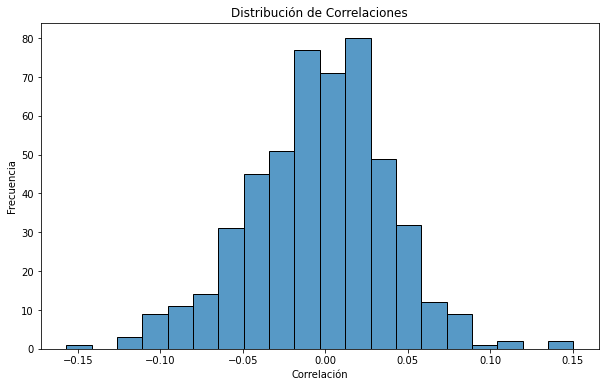

In [15]:
#grafica de correlacion
plt.figure(figsize=(10, 6))
sns.histplot(df_corr['correlation'], bins=20)
plt.title('Distribución de Correlaciones')
plt.xlabel('Correlación')
plt.ylabel('Frecuencia')
plt.show()


La mayoría de las palabras tienen valores de correlación cercanos a 0, significa que el texto por sí solo no es un buen predictor de la calificación. Esto puede deberse a que la calificación depende del contexto completo y no solo de palabras individuales.

## Evolución Promedio de la Calificación

In [16]:
# Ver cuales son las fechas minimas y maximas
print(df['date'].min())
print(df['date'].max())

Dec 01, 2019
Nov 30, 2019


In [17]:
df['date'] = pd.to_datetime(df['date'])
df_grouped = df.groupby(df['date'].dt.to_period("M"))['rating'].mean()

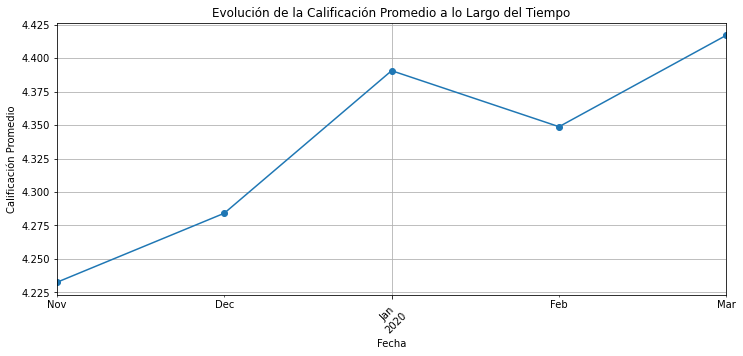

In [18]:
plt.figure(figsize=(12, 5))
df_grouped.plot(marker='o', linestyle='-')
plt.title("Evolución de la Calificación Promedio a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Calificación Promedio")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Hay una tendencia creciente en los reviews de los bancos

## Distribución de Calificaciones por Banco

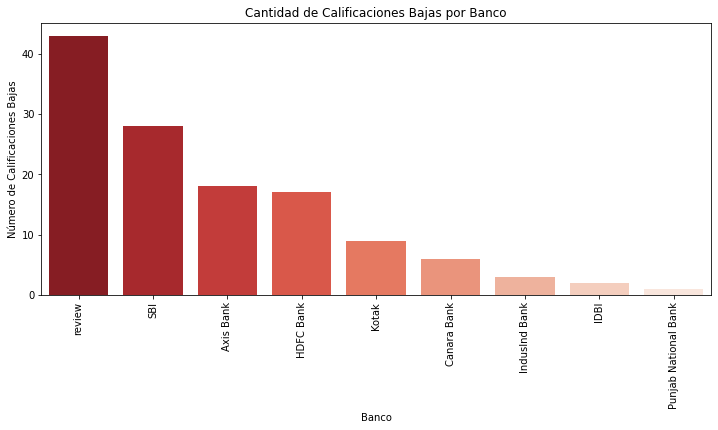

In [19]:
# Definir calificaciones bajas como 1, 2 y 3 estrellas
low_ratings = df[df['rating'] <= 3]

# Contar cuántas calificaciones bajas tiene cada banco
low_ratings_count = low_ratings['bank'].value_counts()

# Graficar
plt.figure(figsize=(12, 5))
sns.barplot(x=low_ratings_count.index, y=low_ratings_count.values, palette="Reds_r")
plt.xticks(rotation=90)
plt.title("Cantidad de Calificaciones Bajas por Banco")
plt.xlabel("Banco")
plt.ylabel("Número de Calificaciones Bajas")
plt.show()

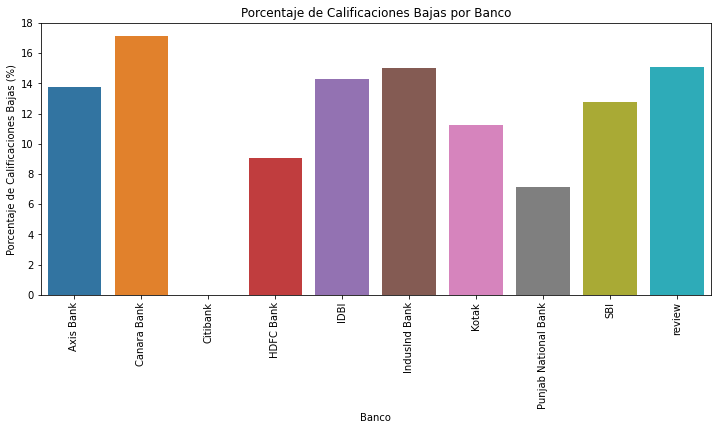

In [20]:
# Contar total de calificaciones por banco
total_ratings_count = df['bank'].value_counts()

# Calcular porcentaje de calificaciones bajas
low_ratings_percentage = (low_ratings_count / total_ratings_count) * 100

# Graficar
plt.figure(figsize=(12, 5))
sns.barplot(x=low_ratings_percentage.index, y=low_ratings_percentage.values)
plt.xticks(rotation=90)
plt.title("Porcentaje de Calificaciones Bajas por Banco")
plt.xlabel("Banco")
plt.ylabel("Porcentaje de Calificaciones Bajas (%)")
plt.show()

- Canara Bank tiene el mayor porcentaje de calificaciones bajas (~16-17%), lo que sugiere una mayor insatisfacción entre sus clientes en comparación con otros bancos.
- IndusInd Bank e IDBI también presentan porcentajes altos (~14-15%), lo que indica que estos bancos tienen un volumen considerable de clientes descontentos.
- Punjab National Bank tiene el menor porcentaje de calificaciones bajas (~9%), lo que sugiere una mejor percepción general del servicio.
- El banco etiquetado como "review" tiene una alta proporción de calificaciones bajas (~14-15%), lo que podría ser un error en la categorización de los datos (tal vez representa un conjunto mixto de reseñas no asignadas a un banco específico).
- HDFC Bank y Kotak tienen valores moderados (~10-12%), lo que indica que aunque tienen reseñas negativas, su impacto relativo es menor.

## Relación entre Rating y Sentimiento del Texto

Limpiamos el texto

In [21]:
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()  # Minúsculas
    text = text.translate(str.maketrans('', '', string.punctuation))  # Quitar puntuación
    tokens = word_tokenize(text)  # Tokenizar
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Eliminar stopwords
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [22]:
df['clean_review'].head()

0    state bank india located nearby area open savi...
1    salary account sbi applied card got statement ...
2    using axis bank saving account past 3years tra...
3    salary bank account hdfc bank many years got b...
4    close around 10 years holding corporation bank...
Name: clean_review, dtype: object

VADER es un módulo de la biblioteca NLTK que analiza el sentimiento de un texto. VADER significa "Valence Aware Dictionary for Sentiment Reasoning". 

¿Qué hace VADER? 
- Analiza el tono emocional de un texto
- Asigna puntuaciones de sentimiento a las palabras
- Calcula la puntuación general del sentimiento del texto


¿Cómo funciona VADER? 
- Divide el texto en palabras individuales
- Califica cada palabra como positiva o negativa
- Calcula la puntuación general del sentimiento del texto


¿Para qué se usa VADER?
- Para analizar el sentimiento de textos breves y de redes sociales 
- Para analizar comentarios o textos de las redes sociales 


¿Qué métricas usa VADER?
- Positivo (pos): Proporción de palabras positivas en la reseña.
- Negativo (neg): Proporción de palabras negativas en la reseña.
- Neutral (neu): Proporción de palabras neutrales en la reseña.
- Score compuesto (compound): Un valor entre -1 (muy negativo) y 1 (muy positivo).

Interpretación del compound score:

- Negativo: compound < -0.05
- Neutral: -0.05 <= compound <= 0.05
- Positivo: compound > 0.05

In [25]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Aplicar análisis de sentimiento
df['sentiment'] = df['review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
df['sentiment'].describe()

count    1000.000000
mean        0.353760
std         0.477309
min        -0.929900
25%         0.000000
50%         0.476050
75%         0.750100
max         0.980200
Name: sentiment, dtype: float64

Podemos ver que en promedio, las reseñas tienden a ser ligeramente positivas. 

Ahora veamos la relacion entre el rating y el puntaje del sentimiento.

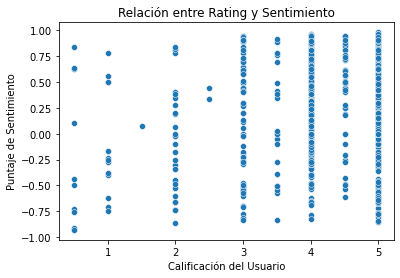

In [28]:
sns.scatterplot(x=df['rating'], y=df['sentiment'])
plt.title("Relación entre Rating y Sentimiento")
plt.xlabel("Calificación del Usuario")
plt.ylabel("Puntaje de Sentimiento")
plt.show()

In [29]:
df[['rating', 'sentiment']].corr()


,rating,sentiment
rating,1.000000,0.255838
sentiment,0.255838,1.000000


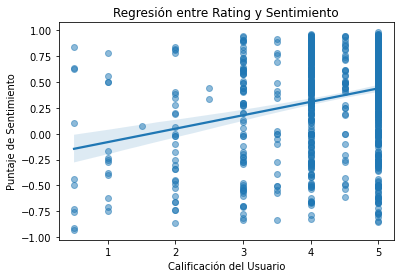

In [30]:
sns.regplot(x=df['rating'], y=df['sentiment'], scatter_kws={'alpha':0.5})
plt.title("Regresión entre Rating y Sentimiento")
plt.xlabel("Calificación del Usuario")
plt.ylabel("Puntaje de Sentimiento")
plt.show()

Podemos ver que existe una relación positiva entre sentimiento y rating, pero es débil y con mucha variabilidad. Esto sugiere que el análisis de sentimientos no es suficiente para predecir el rating